In [ ]:
#Loretta Gray 7.5 Gradient Boosted Tree Regression Commented Hw6
'''
Gradient Boosted Trees (GBT):

Modeling Approach: GBT builds trees sequentially, where each tree tries to correct
the errors of the previous one. It focuses on the residuals (errors) left by prior
trees.
Ensemble Method: Boosting is used, which means trees are added one at a time, and
each subsequent tree minimizes the errors of the previous ones.
Strength: Often leads to higher accuracy but is more prone to overfitting,
especially with noisy data.
'''

In [ ]:
''' This code initializes a Spark session for a PySpark application. It starts by setting
up the environment for Spark with the findspark.init() method, which makes the Spark
library accessible. Then, it imports the necessary module to create a Spark session,
which is the entry point for working with PySpark. The session is configured with a
custom application name ("Python Spark GBTRegressor example") and an optional
configuration setting. Finally, it creates or retrieves an existing Spark session. '''

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark GBTRegressor example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/10 23:02:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/10 23:02:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
''' This code reads a CSV file ("Advertising.csv") into a DataFrame with inferred
schema and header options enabled. It then displays the first 5 rows of the DataFrame
and prints its schema. '''

df = spark.read.format('csv') \
    .options(header='true', inferschema='true') \
    .load("file:///Users/ellegreyllc/Desktop/Advertising.csv")

df.show(5, True)
df.printSchema()



+-----+-----+---------+-----+
|   TV|Radio|Newspaper|Sales|
+-----+-----+---------+-----+
|230.1| 37.8|     69.2| 22.1|
| 44.5| 39.3|     45.1| 10.4|
| 17.2| 45.9|     69.3|  9.3|
|151.5| 41.3|     58.5| 18.5|
|180.8| 10.8|     58.4| 12.9|
+-----+-----+---------+-----+
only showing top 5 rows

root
 |-- TV: double (nullable = true)
 |-- Radio: double (nullable = true)
 |-- Newspaper: double (nullable = true)
 |-- Sales: double (nullable = true)



In [ ]:
df.describe().show()

25/02/10 23:13:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+
|summary|               TV|             Radio|         Newspaper|             Sales|
+-------+-----------------+------------------+------------------+------------------+
|  count|              200|               200|               200|               200|
|   mean|         147.0425|23.264000000000024|30.553999999999995|14.022500000000003|
| stddev|85.85423631490805|14.846809176168728| 21.77862083852283| 5.217456565710477|
|    min|              0.7|               0.0|               0.3|               1.6|
|    max|            296.4|              49.6|             114.0|              27.0|
+-------+-----------------+------------------+------------------+------------------+



In [ ]:
#Convert the data to dense vector (features and label)

In [ ]:
''' This code transforms the DataFrame by converting each row into a feature
vector (excluding the last column) and assigns the last column as the label.
It then creates a new DataFrame with two columns: 'features' (containing the
feature vector) and 'label' (containing the target variable). Finally, it
displays the first 5 rows of the transformed DataFrame. '''

from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

transformed=df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[230.1,37.8,69.2]| 22.1|
| [44.5,39.3,45.1]| 10.4|
| [17.2,45.9,69.3]|  9.3|
|[151.5,41.3,58.5]| 18.5|
|[180.8,10.8,58.4]| 12.9|
+-----------------+-----+
only showing top 5 rows



In [ ]:
#Deal with the Categorical variables

In [ ]:
''' This code applies a VectorIndexer to the 'features' column, which is used to
index categorical features (if any) in the dataset. It creates a new column,
'indexedFeatures', to store the indexed features. The maxCategories parameter
is set to 4, meaning any feature with more than 4 distinct categories will be
treated as continuous. The transformed data is then displayed with the
first 5 rows. '''

from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)
data.show(5,True)

+-----------------+-----+-----------------+
|         features|label|  indexedFeatures|
+-----------------+-----+-----------------+
|[230.1,37.8,69.2]| 22.1|[230.1,37.8,69.2]|
| [44.5,39.3,45.1]| 10.4| [44.5,39.3,45.1]|
| [17.2,45.9,69.3]|  9.3| [17.2,45.9,69.3]|
|[151.5,41.3,58.5]| 18.5|[151.5,41.3,58.5]|
|[180.8,10.8,58.4]| 12.9|[180.8,10.8,58.4]|
+-----------------+-----+-----------------+
only showing top 5 rows



In [ ]:
#Split the data into training and test sets (40% held out for testing)

In [ ]:
''' This code splits the data into two subsets: 60% for training (trainingData) and 40%
for testing (testData). It then displays the first 5 rows of both the training and test datasets. '''

# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5)
testData.show(5)

+---------------+-----+---------------+
|       features|label|indexedFeatures|
+---------------+-----+---------------+
| [0.7,39.6,8.7]|  1.6| [0.7,39.6,8.7]|
| [4.1,11.6,5.7]|  3.2| [4.1,11.6,5.7]|
| [5.4,29.9,9.4]|  5.3| [5.4,29.9,9.4]|
|[7.3,28.1,41.4]|  5.5|[7.3,28.1,41.4]|
| [8.4,27.2,2.1]|  5.7| [8.4,27.2,2.1]|
+---------------+-----+---------------+
only showing top 5 rows

+----------------+-----+----------------+
|        features|label| indexedFeatures|
+----------------+-----+----------------+
| [7.8,38.9,50.6]|  6.6| [7.8,38.9,50.6]|
|   [8.6,2.1,1.0]|  4.8|   [8.6,2.1,1.0]|
|[11.7,36.9,45.2]|  7.3|[11.7,36.9,45.2]|
|[13.2,15.9,49.6]|  5.6|[13.2,15.9,49.6]|
|[16.9,43.7,89.4]|  8.7|[16.9,43.7,89.4]|
+----------------+-----+----------------+
only showing top 5 rows



In [ ]:

#Fit RandomForest Regression Model with GBTRegressor

In [ ]:
''' This code imports the GBTRegressor class and initializes a Gradient Boosted Tree (GBT)
regression model. The model can be customized with parameters like numTrees, maxDepth, and seed,
though they are not specified here. '''

# Import LinearRegression class
from pyspark.ml.regression import GBTRegressor

# Define LinearRegression algorithm
gbt = GBTRegressor() #numTrees=2, maxDepth=2, seed=42

In [ ]:
#If you decide to use the indexedFeatures features, you need to add the parameter
#featuresCol="indexedFeatures".

#Pipeline Architecture

In [ ]:
# This code creates a machine learning pipeline by chaining the featureIndexer and the GBTRegressor model as stages.
# The pipeline is then fitted on the trainingData to create a trained model.
pipeline = Pipeline(stages=[featureIndexer, gbt])
model = pipeline.fit(trainingData)


In [ ]:
#Make predictions

In [ ]:
# This code applies the trained model to the testData to make predictions.
# It then selects and displays the 'features', 'label', and 'prediction' columns for the first 5 rows.
predictions = model.transform(testData)
predictions.select("features","label", "prediction").show(5)


+----------------+-----+------------------+
|        features|label|        prediction|
+----------------+-----+------------------+
| [7.8,38.9,50.6]|  6.6| 5.392609340006243|
|   [8.6,2.1,1.0]|  4.8|5.4001219857107525|
|[11.7,36.9,45.2]|  7.3| 7.162429563793351|
|[13.2,15.9,49.6]|  5.6| 6.224469724420384|
|[16.9,43.7,89.4]|  8.7| 7.897202814926925|
+----------------+-----+------------------+
only showing top 5 rows



25/02/10 23:37:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [ ]:
#Evaluation

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.36147


In [ ]:
# This code uses a RegressionEvaluator to compute the R-squared (R2) metric,
# which measures the model's goodness of fit on the test data by comparing predictions with actual labels.
# It then prints the R-squared value.
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
print("R Squared (R2) on test data = %g" % evaluator.evaluate(predictions))


R Squared (R2) on test data = 0.923398


In [ ]:
# This code retrieves and displays the feature importances from the trained Gradient Boosted Trees model.
# Feature importances represent the relative importance of each feature in making predictions.
importances = model.stages[-1].featureImportances
print("Feature Importances: ", importances)


Feature Importances:  (3,[0,1,2],[0.5972526434076401,0.3504579453305147,0.052289411261845185])


In [ ]:
# This code retrieves the individual decision trees from the trained Gradient Boosted Trees model.
# The `model.stages[-1]` accesses the GBT model, and `.trees` returns a list of all the decision trees that were trained.
trees = model.stages[-1].trees
for tree in trees:
    print("Trained Decision Tree: \n", tree)

Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_896b44019fdd, depth=5, numNodes=63, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_6dbd5d9b90ae, depth=5, numNodes=41, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_f77b92679068, depth=5, numNodes=41, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_4800d310f344, depth=5, numNodes=43, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_db0aaa0e703f, depth=5, numNodes=55, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_65fdbc1f6fe0, depth=5, numNodes=55, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_d26069028595, depth=5, numNodes=51, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_6314e8a91596, depth=5, numNodes=55, numFeatures=3
Trained Decision Tree: 
 DecisionTreeRegressionModel: uid=dtr_d94ce6270a17, depth=5, numNodes=47, numFea

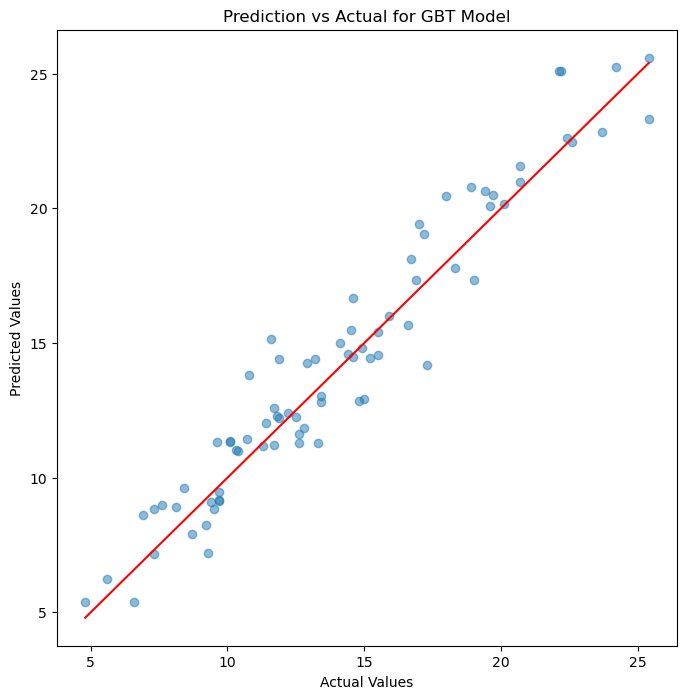

In [ ]:

'''I wanted to visualize the data for a Gradient Boosted Trees (GBT) regression model, you can use the
following three different types of plots:

1. Prediction vs. Actual Plot
This plot compares the predicted values versus the actual values from the test set, which shows how
well the model's predictions match the real data.
'''
# Extracting predictions and actual values
predicted_values = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
actual_values = predictions.select("label").rdd.flatMap(lambda x: x).collect()

# Plotting prediction vs actual
plt.figure(figsize=(8,8))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual for GBT Model')
plt.show()


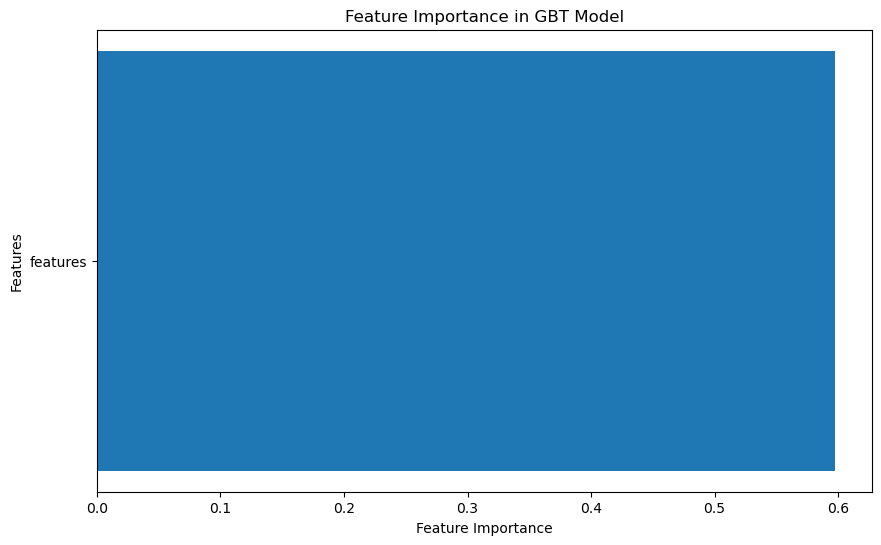

In [ ]:

2. Feature Importance Plot
This plot shows the relative importance of each feature in the GBT model, helping to identify which
features are contributing most to the model's predictions.
'''
import matplotlib.pyplot as plt
import numpy as np

# Feature importances
importances = model.stages[-1].featureImportances
features = transformed.columns[:-1]

# Plotting the feature importances
plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in GBT Model')
plt.show()

